In [1]:
import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
import numpy as np
import math
import pandas as pd
import re
from datetime import date, datetime, timedelta
import json
from abc import ABCMeta, abstractmethod
import boto3
import snowflake.connector
from io import StringIO
import logging 

logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)
logger.info(f'Starting Notebook')

from utils import *

class Utils():
    @staticmethod
    def to_csv_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        csv_buffer = StringIO()
        content.to_csv(csv_buffer)
        client.put_object(Bucket=bucket, Key=key, Body=csv_buffer.getvalue())
        logger.info(f'Saved to {bucket}/{key}')
    
    @staticmethod
    def to_pkl_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = pickle.dumps(content)
        client.put_object(Bucket=bucket, Key=key, Body=obj)
        logger.info(f'Saved model to {os.path.join(bucket, key)}')
        logger.info(f'Saved to {bucket}/{key}')

    @staticmethod
    def read_csv_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'], na_values="\\N")
        logger.info(f'Read from {bucket}/{key}')
        return df
        
    @staticmethod
    def read_pkl_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        body = obj['Body'].read()
        model = pickle.loads(body)
        logger.info(f'Read from {bucket}/{key}')
        return model    

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError

        
class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )
        return ctx

    
def run_query(querystr, ctx):
    cursor_list = ctx.execute_string(
        querystr
        )
    df = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
    df.columns= df.columns.str.lower()
    return df

import plotly.express as px
def get_simple_plot(df_plt, x, y, grpby, text, title=''):
    if title=='':
        title = f'{y} vs {x}'
    df_plt[grpby] = df_plt[grpby].astype(str)
    fig = px.line(df_plt,
                  x=x, 
                  y=y, 
                  title=title,
                  color=grpby, 
                  hover_data=[text],
                  width=800, height=400)
    fig.show()
    return 


## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

input_bucket="hbo-ingest-datascience-content-dev"
output_bucket="hbo-outbound-datascience-content-dev"
key_path = 'cost_allocation/dev'

INFO:root:Starting Notebook
INFO:matplotlib.font_manager:Generating new fontManager, this may take some time...


Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.7.4, Python Version: 3.6.13, Platform: Linux-4.14.322-170.535.amzn1.x86_64-x86_64-with-glibc2.9
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
INFO:snowflake.connector.connection:Setting use_openssl_only mode to False


In [14]:
query='''
select 
cast(DATE_TRUNC('MONTH',cycle_start_date) as date) as month
,sub_month
,is_cancel
, count(distinct hbo_uuid) as subscriber_count
from max_dev.workspace.user_retain_churn_list_test 
where cast(cycle_start_date as date) <'2023-01-01'
and cast(cycle_expire_date as date) >='2022-01-01'
group by month, sub_month, is_cancel 
'''

# df_churn =  run_query(query, ctx)
df_churn=df_churn.sort_values(by=['month','sub_month','is_cancel'])
df_churn['month'] = pd.to_datetime(df_churn.month)
df_churn = df_churn[(df_churn.sub_month<=24) & (df_churn.month>='2022-01-01')]


df_churnp = df_churn.pivot(index=['month','sub_month'], columns='is_cancel', values='subscriber_count').reset_index()
df_churnp = df_churnp.rename(columns={True: 'is_cancel_true', False: 'is_cancel_false'})
df_churnp=df_churnp.reset_index()


df_churnp['total'] = df_churnp['is_cancel_false'] +  df_churnp['is_cancel_true']
df_churnp['churn_rate'] = df_churnp['is_cancel_true']/df_churnp['total']
df_churnp['tenure_grp'] = 0
df_churnp['tenure_grp'] = np.where(df_churnp['sub_month']<=3, '1-3', df_churnp['tenure_grp'])
df_churnp['tenure_grp'] = np.where((df_churnp['sub_month']>3) & (df_churnp['sub_month']<=6), '4-6', df_churnp['tenure_grp'])
df_churnp['tenure_grp'] = np.where((df_churnp['sub_month']>6) & (df_churnp['sub_month']<=12), '6-12', df_churnp['tenure_grp'])
df_churnp['tenure_grp'] = np.where((df_churnp['sub_month']>12), '>12', df_churnp['tenure_grp'])
df_churnp['composition'] = df_churnp['total'] / df_churnp.groupby('month')['total'].transform('sum')
display(df_churnp.head())

df_churnpm = df_churnp[(df_churnp.sub_month<=24)].groupby(by=['month']).sum().reset_index()
df_churnpm['churn_rate'] = df_churnpm['is_cancel_true']/df_churnpm['total']
display(df_churnpm.head())

df_churnpt = df_churnp.copy()
df_churnpt['weighted_tenure'] = df_churnpt['sub_month'] *df_churnpt['total'] 
df_churnpt = df_churnpt.groupby(by=['month'])


is_cancel,index,month,sub_month,is_cancel_false,is_cancel_true,total,churn_rate,tenure_grp,composition
0,0,2022-01-01,1,1200451,290308,1490759,0.194738,1-3,0.121891
1,1,2022-01-01,2,876509,155778,1032287,0.150906,1-3,0.084404
2,2,2022-01-01,3,469723,61974,531697,0.116559,1-3,0.043474
3,3,2022-01-01,4,543494,55158,598652,0.092137,4-6,0.048948
4,4,2022-01-01,5,836068,53056,889124,0.059672,4-6,0.072699


is_cancel,month,index,sub_month,is_cancel_false,is_cancel_true,total,churn_rate,composition
0,2022-01-01,276,300,11249788,980474,12230262,0.080168,1.0
1,2022-02-01,852,300,11058453,916265,11974718,0.076517,1.0
2,2022-03-01,1428,300,10979098,876824,11855922,0.073957,1.0
3,2022-04-01,2004,300,10855273,801869,11657142,0.068788,1.0
4,2022-05-01,2580,300,10673137,780932,11454069,0.068179,1.0


In [27]:
df_churnpt = df_churnp.copy()
df_churnpt['weighted_tenure'] = df_churnpt['sub_month'] *df_churnpt['total'] 
df_churnpt = df_churnpt.groupby(by=['month']).sum()
df_churnpt['weighted_avg_tenure'] = df_churnpt['weighted_tenure']/df_churnpt['total']
df_churnpt = df_churnpt.reset_index()
df_churnpt

is_cancel,month,index,sub_month,is_cancel_false,is_cancel_true,total,churn_rate,composition,weighted_tenure,weighted_avg_tenure
0,2022-01-01,276,300,11249788,980474,12230262,1.781449,1.0,107918439,8.823886
1,2022-02-01,852,300,11058453,916265,11974718,1.588892,1.0,112654422,9.407689
2,2022-03-01,1428,300,10979098,876824,11855922,1.536528,1.0,121335995,10.234210
3,2022-04-01,2004,300,10855273,801869,11657142,1.447725,1.0,127075020,10.901044
4,2022-05-01,2580,300,10673137,780932,11454069,1.538764,1.0,133225902,11.631317
5,2022-06-01,3156,300,9676691,731825,10408516,1.603166,1.0,119702583,11.500447
6,2022-07-01,3732,300,9309967,722411,10032378,1.672263,1.0,119305599,11.892056
7,2022-08-01,4308,300,9324563,714875,10039438,1.582097,1.0,119844965,11.937418
8,2022-09-01,4884,300,9110898,668211,9779109,1.509509,1.0,118917007,12.160311
9,2022-10-01,5460,300,8845917,730832,9576749,1.705408,1.0,120427697,12.575008


In [10]:
df_churnp.head()

is_cancel,index,month,sub_month,is_cancel_false,is_cancel_true,total,churn_rate,tenure_grp,composition
0,0,2022-01-01,1,1200451,290308,1490759,0.194738,1-3,0.121891
1,1,2022-01-01,2,876509,155778,1032287,0.150906,1-3,0.084404
2,2,2022-01-01,3,469723,61974,531697,0.116559,1-3,0.043474
3,3,2022-01-01,4,543494,55158,598652,0.092137,4-6,0.048948
4,4,2022-01-01,5,836068,53056,889124,0.059672,4-6,0.072699


In [16]:
df_churnpm

is_cancel,month,index,sub_month,is_cancel_false,is_cancel_true,total,churn_rate,composition
0,2022-01-01,276,300,11249788,980474,12230262,0.080168,1.0
1,2022-02-01,852,300,11058453,916265,11974718,0.076517,1.0
2,2022-03-01,1428,300,10979098,876824,11855922,0.073957,1.0
3,2022-04-01,2004,300,10855273,801869,11657142,0.068788,1.0
4,2022-05-01,2580,300,10673137,780932,11454069,0.068179,1.0
5,2022-06-01,3156,300,9676691,731825,10408516,0.070310,1.0
6,2022-07-01,3732,300,9309967,722411,10032378,0.072008,1.0
7,2022-08-01,4308,300,9324563,714875,10039438,0.071207,1.0
8,2022-09-01,4884,300,9110898,668211,9779109,0.068330,1.0
9,2022-10-01,5460,300,8845917,730832,9576749,0.076313,1.0


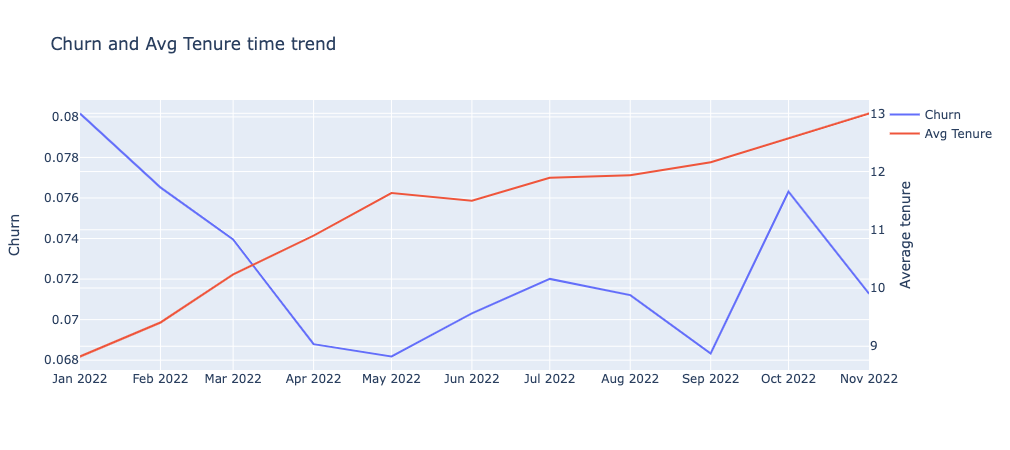

In [30]:
import plotly.graph_objects as go


# fig= px.line(df_churnpm, x='month', y='churn_rate')
# fig2 = fig.twinx()
# fig2.add_scatter(x=df_churnpt['month'], y=df_churnpt['weighted_avg_tenure'], mode='lines', name='Y2', line=dict(color='red'))


# fig.show()


fig = go.Figure()

# Add the first line to the plot with its own y-axis
fig.add_trace(go.Scatter(x=df_churnpm[df_churnpm.month<='2022-11-01']['month'], y=df_churnpm['churn_rate'], mode='lines', name='Churn', yaxis='y'))

# Add the second line to the plot with its own y-axis
fig.add_trace(go.Scatter(x=df_churnpt[df_churnpt.month<='2022-11-01']['month'], y=df_churnpt['weighted_avg_tenure'], mode='lines', name='Avg Tenure', yaxis='y2'))

# Define y-axis titles
fig.update_layout(
    yaxis=dict(title='Churn'),
    yaxis2=dict(title='Average tenure', overlaying='y', side='right')
)

# Update the layout
fig.update_layout(title='Churn and Avg Tenure time trend')

# Show the plot
fig.show()

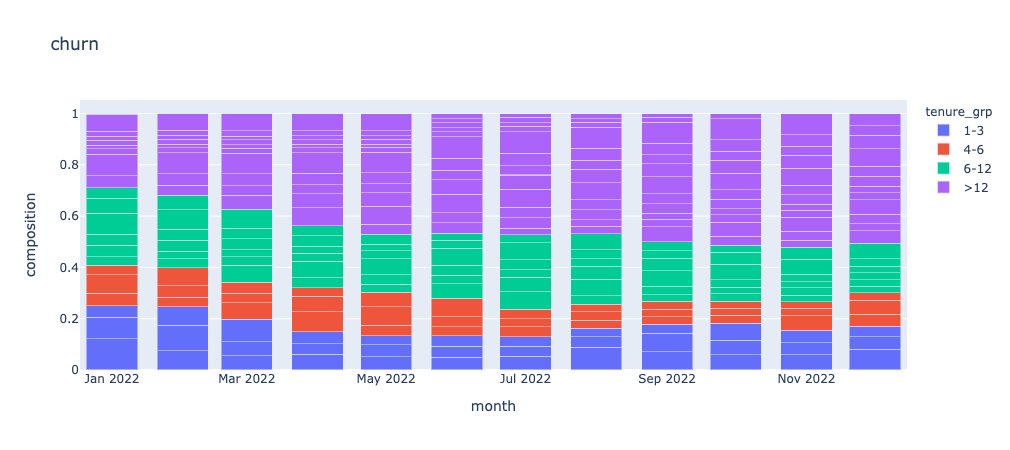

AttributeError: 'Figure' object has no attribute 'twinx'

In [20]:
# df_plt = df_churnp[df_churnp.sub_month<=12]
import plotly.express as px
title = 'churn'
df_plt=df_churnp.copy()
fig = px.bar(df_plt, x='month', y='composition', color='tenure_grp', title=title,
             labels={'A': 'tenure_grp', 'B': 'composition'})

fig.update_layout(barmode='stack')  # Set the bar mode to 'stack' for stacking bars
fig.show()


title = 'total'
df_plt = df_churnp[df_churnp.sub_month<=12]
fig = px.bar(df_plt, x='month', y='total', color='sub_month', title=title,
             labels={'A': 'sub_month', 'B': 'total'})

fig.update_layout(barmode='stack')  # Set the bar mode to 'stack' for stacking bars

fig.show()


In [99]:
## Title availability 

query_title='''
WITH dates AS (
  SELECT DATEADD(DAY, seq4(), '2022-01-01') AS date
  FROM TABLE(GENERATOR(ROWCOUNT => 365))
)
SELECT
  d.date
  , rad.title_name
  , rad.viewable_id
  , rad.season_number
  , am.home_territory_observed_medal as medal
  , rad.content_category as content_category
  , rad.primary_genre_desc as genre
  , aod.offering_start_date
  , aod.offering_end_date
from dates d
left join max_prod.catalog.asset_offering_dim aod
on d.date BETWEEN aod.offering_start_date AND aod.offering_end_date
left join max_prod.catalog.reporting_asset_dim rad
    on aod.viewable_id = rad.viewable_id
left join max_prod.content_analytics.asset_medals am 
    on rad.title_id = am.title_id
where aod.territory='HBO MAX DOMESTIC'
order by date
'''

df =  run_query(query_title, ctx)
display(df.head())


INFO:snowflake.connector.cursor:query: [WITH dates AS ( SELECT DATEADD(DAY, seq4(), '2022-01-01') AS date FROM TABLE(GEN...]
INFO:snowflake.connector.cursor:query execution done


,date,title_name,viewable_id,season_number,medal,content_category,genre,offering_start_date,offering_end_date
0,2022-01-01,In Treatment,GVU4JLQbpQI7DwvwIAbd5,1.0,Bronze,series,drama,2020-11-10 11:00:00,2025-02-28 10:59:00
1,2022-01-01,The Wayans Bros.,GX_zO_gRGysMuwgEAAABy,4.0,None,series,comedy,2021-01-15 08:01:00,2025-01-15 04:59:59
2,2022-01-01,Veneno: Sn 1 / Ep 2 Sneak Peek,GX7WBugQVRkQWnQEAAAAw,NaN,None,None,None,2020-11-19 20:00:00,2030-12-10 04:59:00
3,2022-01-01,The Boondocks,GXpSh1AHYJgwlRQEAAAXl,1.0,None,series,not_a_genre,2020-05-06 04:00:00,2026-01-07 04:59:59
4,2022-01-01,Black Jesus,GYS3D0A1qGZTDwgEAAACd,2.0,None,series,comedy,2021-12-24 08:01:00,2024-12-24 04:59:00


In [107]:
df

,date,title_name,viewable_id,season_number,medal,content_category,genre,offering_start_date,offering_end_date,month
0,2022-01-01,In Treatment,GVU4JLQbpQI7DwvwIAbd5,1.0,Bronze,series,drama,2020-11-10 11:00:00,2025-02-28 10:59:00,2022-01-01
1,2022-01-01,The Wayans Bros.,GX_zO_gRGysMuwgEAAABy,4.0,None,series,comedy,2021-01-15 08:01:00,2025-01-15 04:59:59,2022-01-01
2,2022-01-01,Veneno: Sn 1 / Ep 2 Sneak Peek,GX7WBugQVRkQWnQEAAAAw,NaN,None,None,None,2020-11-19 20:00:00,2030-12-10 04:59:00,2022-01-01
3,2022-01-01,The Boondocks,GXpSh1AHYJgwlRQEAAAXl,1.0,None,series,not_a_genre,2020-05-06 04:00:00,2026-01-07 04:59:59,2022-01-01
4,2022-01-01,Black Jesus,GYS3D0A1qGZTDwgEAAACd,2.0,None,series,comedy,2021-12-24 08:01:00,2024-12-24 04:59:00,2022-01-01
...,...,...,...,...,...,...,...,...,...,...
38954527,2023-07-14,Rock Dog: Trailer,GYxBWxwHsRZa8kAEAAAiH,NaN,None,None,None,2022-10-01 07:01:00,2024-01-01 08:00:00,2023-07-01
38954537,2023-07-14,Show Me A Hero: Sn 1 / Ep 3 Recap,GVdO6sQF9yU-PpJIIAABz,NaN,None,None,None,2020-08-28 10:00:00,2024-03-31 09:59:00,2023-07-01
38954543,2023-07-14,The Sentinel: Trailer,GY6Sr5QOHzJfDVQEAAAjZ,NaN,None,None,None,2023-01-01 08:01:00,2023-09-01 07:00:00,2023-07-01
38954545,2023-07-14,Mexican Labor: South Park Clip,GXvosiwnaSoaEUwEAAAQd,NaN,None,None,None,2020-07-14 10:00:00,2025-06-24 03:59:00,2023-07-01


In [117]:
# df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
# df = df.drop_duplicates(subset=['title_name','month'])
df['medal'] = df['medal'].fillna('other')
df_grp = df.groupby(by=['month']).title_name.count().reset_index()
df_grp_medal = df[df.medal!='other'].groupby(by=['medal','month']).title_name.count().reset_index()



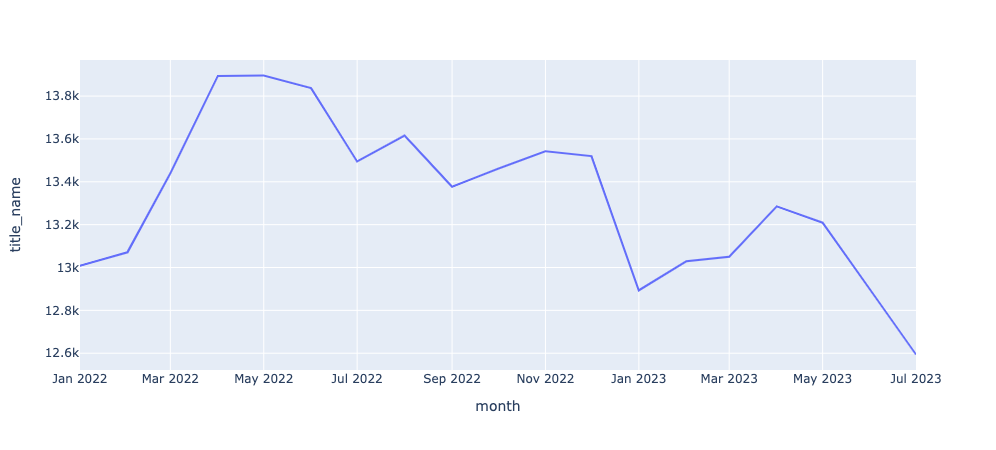

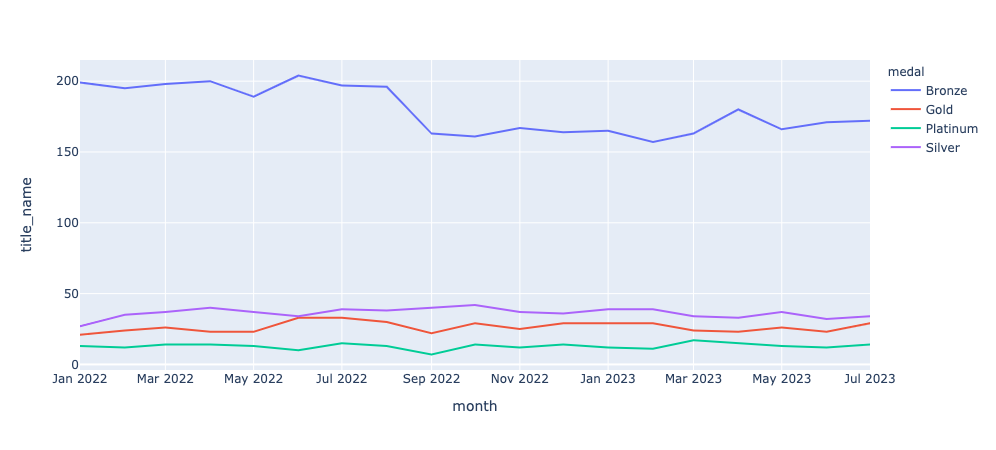

In [118]:

fig= px.line(df_grp, x='month', y='title_name')
fig.show()

fig= px.line(df_grp_medal, x='month', y='title_name',color='medal')
fig.show()
